<a href="https://colab.research.google.com/github/nihalsuri/thermal-anomaly-detection/blob/main/notebooks/full_connected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading all necessary data when connected to host

In [1]:
! gdown --id 1x4Os51uaMXDILTGo2Y_lOC9HU1jTnzi0
! gdown --id 1uxDV-sgzDUATHc5p8gW_gBKBsEVrz34x

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!unzip clutch_2.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Uploading data when connected to local runtime 

In [3]:
annotations_path = 'C:/Users/Nihal/Desktop/thesis/dataset.csv'
# annotations_path = 'C:/Users/Nihal/Desktop/new_dataset.csv'
dataset_path = 'C:/Users/Nihal/Desktop/thesis/clutch_2'

# Data preperation for training

In this section the following is done: 



*   Data is processed and arranged into respective **dataframes** 
*   **Custom dataset** class is created 
*   **Transforms** are done on the various datasets
*   **Dataloaders** are created for the purposes of iteration





## Import libraries

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from torchvision import transforms , models
from sklearn import metrics
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import io
import copy
import tqdm 
import time 

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name()
print(device_name)
print(device)

NVIDIA GeForce GTX 1660 Ti with Max-Q Design
cuda


In [6]:
torch.cuda.empty_cache()

In [7]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

## Split data into dataframes

In [8]:
df = pd.read_csv(annotations_path)
train_df = df[df['dataset'].str.contains('train')]
test_df = df[df['dataset'].str.contains('test')]
val_df = df[df['dataset'].str.contains('val')]
print(train_df.shape[0])
print(test_df.shape[0])
print(val_df.shape[0])

2703
651
648


In [9]:
# img_paths = df["img_path"]

In [10]:
# for i in range(img_paths.shape[0]):
#   size  = len(img_paths.at[i])
#   new_path = img_paths.at[i][:size - 24]
#   img_paths.at[i] = new_path


In [11]:
# img_paths.head()

In [12]:
# unique_lables = img_paths.unique().tolist()


In [13]:
# df_freq = img_paths.value_counts()
# df_freq

## Custom Class 
Returns **image** and **label** for futher training

In [14]:
class ClutchDataset(Dataset):

    def __init__(self, dataframe, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1])
        image1 = cv2.imread(img_name)
        image_norm = cv2.normalize(
            image1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        image = Image.fromarray(image_norm)
        label = torch.tensor(int(self.dataframe.iloc[idx, 2]))
         


        if self.transform:
            image = self.transform(image)
        
        #image = transforms.functional.crop(image, 140, 360 , 240, 240) # take only right part of the system
        #image = transforms.functional.crop(image, 220, 460 , 160, 160) # take only right tip of the system 1 
        #image = transforms.functional.crop(image, 190, 510 , 140, 110) # more right 2
        #image = transforms.functional.crop(image, 190, 470 , 140, 140) # more right 3
        #image = transforms.functional.crop(image, 190, 440 , 140, 180) # more right 4
        #image = transforms.functional.crop(image, 190, 470 , 130, 150) # more right 5
        
        #image = transforms.functional.crop(image, 190, 285 , 140, 320) # mm
        #image = transforms.functional.crop(image, 190, 380 , 140, 230)
        #image = transforms.functional.crop(image, 190, 430 , 140, 180) #6

        return image, label

## Transforms on the datasets

In [15]:
# Add transforms for train, test, val dataset
input_size_h = 512
input_size_w = 640
transform_train = transforms.Compose([
   #transforms.Resize((input_size_h, input_size_w)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.RandomPerspective(),
    #transforms.RandomRotation((1, 8))

])

transform_valid = transforms.Compose([
    #transforms.Resize((input_size_h, input_size_w)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    #transforms.Resize((input_size_h, input_size_w)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

## Dataloaders and Iterator

Feature batch shape: torch.Size([8, 1, 512, 640])
Labels batch shape: torch.Size([8])


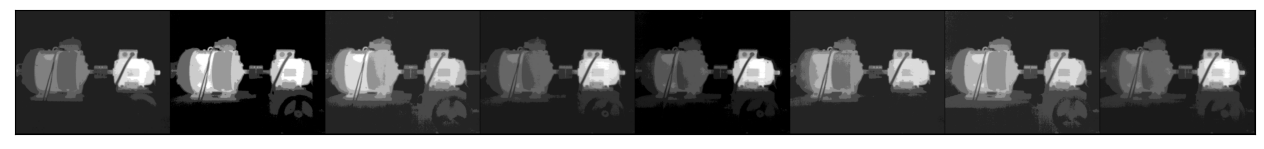

In [16]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break



# dataloaders
train_dataset = ClutchDataset(
    train_df, root_dir=dataset_path, is_train=True, transform=transform_train)
val_dataset = ClutchDataset(val_df, root_dir=dataset_path,
                            is_train=False, transform=transform_valid)
test_dataset = ClutchDataset(
    test_df, root_dir=dataset_path, is_train=False, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader
dataloaders_dict['test'] = test_loader


# iteratre through dataloaders
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]

# convert image to APPEAR RGB
# rgb_train_features = np.repeat(train_features[..., np.newaxis], 3, -1)
# print(f"Feature batch shape: {rgb_train_features.shape}")
# train_features = rgb_train_features

# plt.imshow(img, cmap="gray")
# plt.axis('off')
# plt.show()
# print(f"Label: {label}")
show_batch(train_loader)






# Neural Networks
Various different NNs tested with the same dataset

### Metrics

In [17]:
def get_metrics(y_true, y_pred, class_mapping):

    total_predictions = [0, 0, 0]
    total_true = [0, 0, 0]

    cm = metrics.confusion_matrix(y_true, y_pred, labels=class_mapping)

    for i in range(3):
        for j in range(3):
            total_predictions[i] += cm[j][i]
            total_true[i] += cm[i][j]

    # recall and precision for each class
    r_h = cm[0][0] / total_predictions[0]
    r_m = cm[1][1] / total_predictions[1]
    r_r = cm[2][2] / total_predictions[2]
    p_h = cm[0][0] / total_true[0]
    p_m = cm[1][1] / total_true[1]
    p_r = cm[2][2] / total_true[2]

    # data for confusion matrix
    data = [["", class_mapping[0], class_mapping[1], class_mapping[2], "Total actual"],
            [class_mapping[0], cm[0][0], cm[0][1], cm[0][2], total_true[0]],
            [class_mapping[1], cm[1][0], cm[1][1], cm[1][2], total_true[1]],
            [class_mapping[2], cm[2][0], cm[2][1], cm[2][2], total_true[2]],
            ["Total predicted:", total_predictions[0], total_predictions[1], total_predictions[2], sum(total_true)]]

    # data for f1 score for each class
    data_f1 = [["Class", "F1-score"],
               ["Healthy", round((2 * p_h * r_h) / (p_h + r_h), 2)],
               ["Misalignment", round((2 * p_m * r_m) / (p_m + r_m), 2)],
               ["Rotor damage", round((2 * p_r * r_r) / (p_r + r_r), 2)]]

    # printing confusion matrix, f1 score table, recall and precision
    print(tabulate(data, tablefmt="simple_grid"))
    print()
    print(tabulate(data_f1, tablefmt="simple_grid"))
    print(f"\nRecall for healthy class: {round(r_h, 2)}")
    print(f"Recall for misalignment class: {round(r_m, 2)}")
    print(f"Recall for rotor damage class: {round(r_r, 2)}")
    print(f"\nPrecision for healthy class: {round(p_h, 2)}")
    print(f"Precision for misalignment class: {round(p_m, 2)}")
    print(f"Precision for rotor damage class: {round(p_r, 2)}")

### Fully Connected



In [18]:
class FeedForwardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_layers = nn.Sequential(
            nn.Linear(640 * 512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        flattened_data = self.flatten(input_data)
        logits = self.dense_layers(flattened_data)
        predictions = self.softmax(logits)
        return predictions

In [19]:
model = FeedForwardNet()
model = model.to(device)

### Hyperparameters

In [20]:
path_res = "C:/Users/Nihal/Desktop/fully-connected.pt"
LEARNING_RATE = 3e-4

loss_val = []
train_acc = []
class_mapping = ['healthy', 'misalignment', 'rotor damage']

### Early Stopping

In [21]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Training per epoch


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
test_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
test_loss = []
test_acc = []
total_step = len(train_loader)
early_stopper = EarlyStopper(patience=5, min_delta=0.1)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 40 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    batch_loss_t = 0
    total_t=0
    correct_t=0

    batch_loss_v = 0
    total_v=0
    correct_v=0


    with torch.no_grad():
        model.eval()
        for data_v, target_v in (val_loader):
            data_v, target_v = data_v.to(device), target_v.to(device)
            outputs_v = model(data_v)
            loss_v = criterion(outputs_v, target_v)
            batch_loss_v += loss_v.item()
            _,pred_v = torch.max(outputs_v, dim=1)
            correct_v += torch.sum(pred_v==target_v).item()
            total_v += target_v.size(0)
        val_acc.append(100 * correct_v/total_v)
        val_loss.append(batch_loss_v/len(val_loader))
        network_learned = batch_loss_v < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_v/total_v):.4f}')

        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss_t += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        test_acc.append(100 * correct_t/total_t)
        test_loss.append(batch_loss_t/len(test_loader))
        network_learned = batch_loss_t < test_loss_min
        print(f'test loss: {np.mean(test_loss):.4f}, test acc: {(100 * correct_t/total_t):.4f}\n')        

        
        if network_learned:
            test_loss_min = batch_loss_t
            torch.save(model.state_dict(), path_res)
            print('Improvement-Detected, save-model')

        if early_stopper.early_stop(batch_loss_t/len(test_loader)):
            print("Patience Extended! Training stopped...")
            break

        

    model.train()










Epoch 1

Epoch [1/30], Step [0/338], Loss: 1.0911
Epoch [1/30], Step [40/338], Loss: 1.0274
Epoch [1/30], Step [80/338], Loss: 0.9768
Epoch [1/30], Step [120/338], Loss: 0.9787
Epoch [1/30], Step [160/338], Loss: 1.0111
Epoch [1/30], Step [200/338], Loss: 0.9153
Epoch [1/30], Step [240/338], Loss: 0.7884
Epoch [1/30], Step [280/338], Loss: 0.7566
Epoch [1/30], Step [320/338], Loss: 0.6689

train-loss: 0.9167, train-acc: 65.8158
validation loss: 0.8965, validation acc: 69.2901
test loss: 0.8981, test acc: 68.3564

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/338], Loss: 0.9683
Epoch [2/30], Step [40/338], Loss: 0.7198
Epoch [2/30], Step [80/338], Loss: 0.8824
Epoch [2/30], Step [120/338], Loss: 0.6960
Epoch [2/30], Step [160/338], Loss: 0.7733
Epoch [2/30], Step [200/338], Loss: 0.6815
Epoch [2/30], Step [240/338], Loss: 0.6353
Epoch [2/30], Step [280/338], Loss: 0.6138
Epoch [2/30], Step [320/338], Loss: 0.6532

train-loss: 0.8108, train-acc: 88.9012
validation loss:

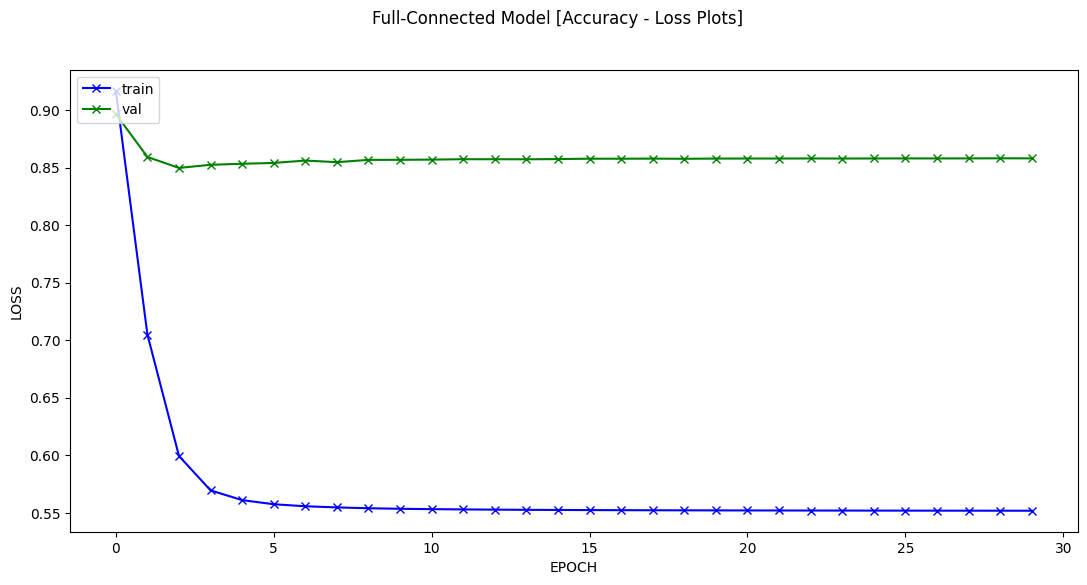

In [30]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(13)


plt.plot(train_loss, 'bx-', label = 'train')
plt.plot(val_loss, 'gx-', label = 'val')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.legend(loc = 'upper left')

# plt.subplot(1, 2, 2)
# # plt.plot(train_acc, 'bx-', label = 'train')
# # plt.plot(val_acc, 'gx-', label = 'val')
# plt.plot(test_acc, 'rx-', label = 'test')
# plt.ylabel('ACCURACY')
# plt.xlabel('EPOCH')
# plt.legend(loc = 'upper left')


fig.suptitle('Full-Connected Model [Accuracy - Loss Plots]')
plt.show()

### Predictions

#### Test

In [27]:
model_net = model
model_net.load_state_dict(torch.load(path_res))


print('Test data: ')
y_true = []
y_pred = []

for i in range(len(test_dataset)):
    input, target = test_dataset[i][0], test_dataset[i][1]
    model_net.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        input = input.to(device) # send data to GPU 
        predictions = model_net(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Test data: 
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 0       │ 0            │ 206          │ 206          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 0       │ 229          │ 0            │ 229          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 0       │ 0            │ 216          │ 216          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 0       │ 229          │ 422          │ 651          │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ nan      │
├──────────────┼──────────┤
│ Misalignm

c:\users\nihal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


#### Validation

In [28]:
print('Valid data: ')
y_true = []
y_pred = []

for i in range(len(val_dataset)):
    input, target = val_dataset[i][0], val_dataset[i][1]
    model_net.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        input = input.to(device) # send data to GPU 
        predictions = model_net(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Valid data: 
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 0       │ 0            │ 199          │ 199          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 0       │ 220          │ 0            │ 220          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 0       │ 0            │ 229          │ 229          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 0       │ 220          │ 428          │ 648          │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ nan      │
├──────────────┼──────────┤
│ Misalign

c:\users\nihal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  


#### Training

In [29]:
print('Training data:')
y_true = []
y_pred = []

for i in range(len(train_dataset)):
    input, target = train_dataset[i][0], train_dataset[i][1]
    model_net.eval()
    with torch.no_grad():
        input = torch.unsqueeze(input, 0)
        input = input.to(device) # send data to GPU
        predictions = model_net(input)
        predicted_index = predictions[0].argmax(0)

        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]

    y_true.append(expected)
    y_pred.append(predicted)

get_metrics(y_true, y_pred, class_mapping)

Training data:
┌──────────────────┬─────────┬──────────────┬──────────────┬──────────────┐
│                  │ healthy │ misalignment │ rotor damage │ Total actual │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ healthy          │ 557     │ 0            │ 0            │ 557          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ misalignment     │ 0       │ 981          │ 0            │ 981          │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ rotor damage     │ 0       │ 0            │ 1165         │ 1165         │
├──────────────────┼─────────┼──────────────┼──────────────┼──────────────┤
│ Total predicted: │ 557     │ 981          │ 1165         │ 2703         │
└──────────────────┴─────────┴──────────────┴──────────────┴──────────────┘

┌──────────────┬──────────┐
│ Class        │ F1-score │
├──────────────┼──────────┤
│ Healthy      │ 1.0      │
├──────────────┼──────────┤
│ Misali